In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
test_spread = pd.read_csv("test_spread.csv", index_col=0) # 2021/08/06+
test_spread_base = pd.read_csv("test_spread_base.csv", index_col=0)
test_z_score = pd.read_csv("test_z_score.csv", index_col=0) # 2021/08/23+
z_score_optim = pd.read_csv("z_score_optim.csv", index_col=0)
test_spread = test_spread.iloc[11:,:] # Resccale to 2021/08/23+
test_spread_base = test_spread_base.iloc[11:,:]  # Resccale to 2021/08/23+

In [4]:
def testing_backtest(params, spread, z_score, base, pair_name):
    long_entryZscore, long_exitZscore, short_entryZscore, short_exitZscore =  params
    PnL = pd.DataFrame({f"{pair_name}(Z_score)": z_score,f"{pair_name}(Spread)": spread})
    PnL.index = pd.to_datetime(z_score.index)
    PnL['long entry'] = (PnL[f"{pair_name}(Z_score)"] < (long_entryZscore)) & (PnL[f"{pair_name}(Z_score)"].shift(1) > (long_entryZscore))
    PnL['long exit'] = (PnL[f"{pair_name}(Z_score)"] > (long_exitZscore)) & (PnL[f"{pair_name}(Z_score)"].shift(1) < (long_exitZscore))
    PnL['num units long'] = np.nan
    PnL.loc[PnL['long entry'],'num units long'] = 1 
    PnL.loc[PnL['long exit'],'num units long'] = 0 
    PnL['num units long'][0] = 0 
    PnL['num units long'] = PnL['num units long'].fillna(method='pad')
            
    PnL['short entry'] = (PnL[f"{pair_name}(Z_score)"] > (short_entryZscore)) & (PnL[f"{pair_name}(Z_score)"].shift(1) < (short_entryZscore))
    PnL['short exit'] = (PnL[f"{pair_name}(Z_score)"] < (short_exitZscore)) & (PnL[f"{pair_name}(Z_score)"].shift(1) > (short_exitZscore))
    PnL['num units short'] = np.nan
    PnL.loc[PnL['short entry'],'num units short'] = -1
    PnL.loc[PnL['short exit'],'num units short'] = 0
    PnL['num units short'][0] = 0 
    PnL['num units short'] = PnL['num units short'].fillna(method='pad')
    
    PnL['numUnits'] = PnL['num units long'] + PnL['num units short']
    PnL['spread pct ch'] = ((spread - spread.shift(1)) / base).values
    PnL['port rets'] = PnL['spread pct ch'] * PnL['numUnits'].shift(1)
    PnL['cum rets'] = PnL['port rets'].cumsum()
    PnL['cum rets'] = PnL['cum rets'] + 1
    end_val = PnL['cum rets'].iat[-1]
    
    end_val = PnL['cum rets'].iat[-1]
    days = (PnL.index[-1] - PnL.index[0]).days
    annual_return = (end_val) ** (252.0/days) - 1

    try:
        sharpe_ratio = ((PnL['port rets'].mean() / PnL['port rets'].std()) * np.sqrt(252))
    except ZeroDivisionError:
        sharpe_ratio = 0.0
    return(PnL, end_val, sharpe_ratio, annual_return)

In [8]:
PnL_list= []
Profit = pd.DataFrame()
Profit.index = test_z_score.columns
Profit["Profit"] = np.zeros(len(test_z_score.columns))
Profit["Sharpe Ratio"] = np.zeros(len(test_z_score.columns))
Profit["Annual Return"] = np.zeros(len(test_z_score.columns))
for pair in range(test_z_score.shape[1]):
    pair_name = test_z_score.columns[pair]
    spread = test_spread.iloc[:,pair]
    z_score = test_z_score[pair_name]
    base = test_spread_base.iloc[:,pair]
    params = [z_score_optim.iloc[pair,1], z_score_optim.iloc[pair,2],z_score_optim.iloc[pair,3], z_score_optim.iloc[pair,4]]
    result = testing_backtest(params, spread, z_score, base, pair_name)
    PnL_list.append(result[0])
    Profit.iloc[pair,:] = result[1:4]
Profit

,Profit,Sharpe Ratio,Annual Return
ORCL GOOGL,2.028062,2.873659,0.230812
USLV GLD,3.770704,3.168001,0.476722
USLV AAPL,3.786548,2.760173,0.478542
USLV GOOGL,3.649733,2.684828,0.462647
USLV AMD,3.745957,2.563864,0.473869
...,...,...,...
CMCSA VDC,1.685310,2.613928,0.165674
CMCSA KXI,1.598368,2.250282,0.147681
CMCSA VHT,1.662834,2.714139,0.161087
CMCSA VNQ,1.552227,1.926653,0.137849


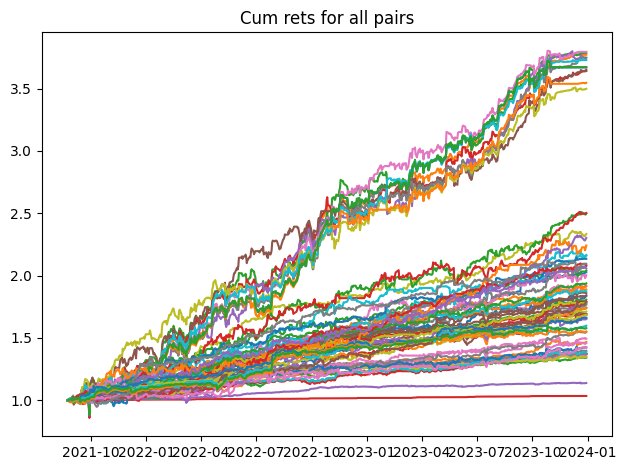

In [9]:
for pair in range(len(PnL_list)):
    plt.plot(PnL_list[pair]["cum rets"].dropna())
plt.title("Cum rets for all pairs")
plt.tight_layout()
plt.show()

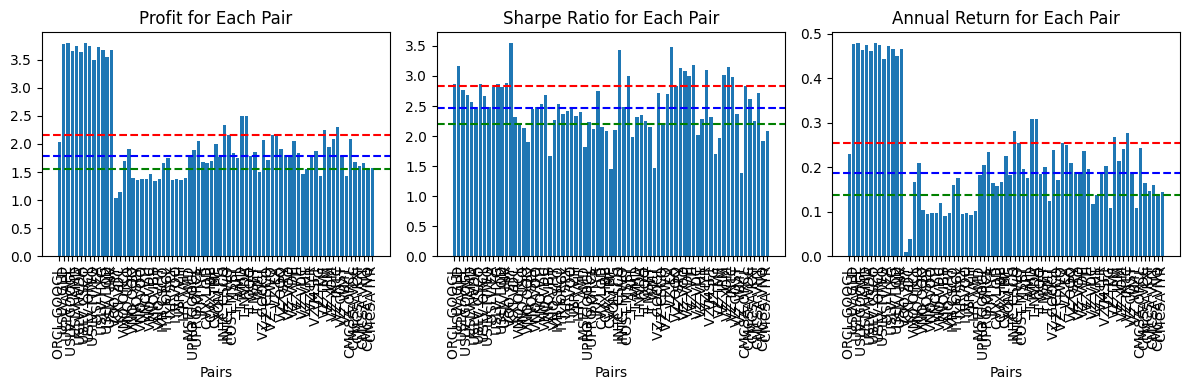

In [10]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))
for col in range(Profit.shape[1]):
    data = Profit.iloc[:,col]
    quartiles = np.percentile(data, [25, 50, 75])
    axs[col].bar(Profit.index, data)
    axs[col].set_xlabel("Pairs")
    axs[col].set_title(f"{Profit.columns[col]} for Each Pair")
    axs[col].tick_params(axis='x', rotation=90)
    axs[col].axhline(quartiles[0], color='green', linestyle='--', label='Lower Quartile')
    axs[col].axhline(quartiles[1], color='blue', linestyle='--', label='Median')
    axs[col].axhline(quartiles[2], color='red', linestyle='--', label='Upper Quartile')
plt.tight_layout()
plt.show()

In [11]:
PnL_ts = pd.DataFrame()
PnL_ts.index =  PnL_list[0].index
for pair in range(len(PnL_list)):
    data = PnL_list[pair]
    pair_name = data.columns[0]
    PnL_ts[pair_name] = data["cum rets"]

In [14]:
ew_PnL = PnL_ts.dropna()
ew_PnL /= len(ew_PnL.columns)
ew_PnL.sum(axis=1)

Index
2021-08-24    1.000000
2021-08-25    1.000233
2021-08-26    1.000577
2021-08-27    1.000360
2021-08-30    1.001011
                ...   
2023-12-22    2.065063
2023-12-26    2.063878
2023-12-27    2.062899
2023-12-28    2.063601
2023-12-29    2.067140
Length: 592, dtype: float64